In [22]:
##Ridge regression 

import os
import matplotlib.pyplot as plt
import numpy as np
import scripts.implementations as lib  # Add personal library
import scripts.proj1_helpers as helper  # Add personal library
import scripts.ml as ml  # Add personal library

%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4)

DATA_FOLDER = 'data'
DATA_TRAIN = os.path.join(DATA_FOLDER, 'train.csv')
DATA_TEST = os.path.join(DATA_FOLDER, 'test.csv')

y, x, ids, header = helper.load_csv_data(DATA_TRAIN)
y_train, x_train,  y_validation, x_validation = lib.sep_valid_train_data(x,y, 0.8);
print(y_train.shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(200000,)


In [23]:
x_train[x_train == -999] = np.nan
x_validation[x_validation == -999] = np.nan

In [24]:
for i, feature in enumerate(x_train.T):
    print('Feature {} - {} has range: [{:.4f}, {:.4f}]'.format(
        i+1, header[i], np.nanmin(feature), np.nanmax(feature)))

Feature 1 - DER_mass_MMC has range: [9.0440, 1192.0260]
Feature 2 - DER_mass_transverse_met_lep has range: [0.0000, 595.8190]
Feature 3 - DER_mass_vis has range: [6.4620, 1329.9130]
Feature 4 - DER_pt_h has range: [0.0000, 1053.8070]
Feature 5 - DER_deltaeta_jet_jet has range: [0.0000, 8.5030]
Feature 6 - DER_mass_jet_jet has range: [13.6020, 4974.9790]
Feature 7 - DER_prodeta_jet_jet has range: [-18.0660, 16.6900]
Feature 8 - DER_deltar_tau_lep has range: [0.2080, 5.6840]
Feature 9 - DER_pt_tot has range: [0.0000, 513.6590]
Feature 10 - DER_sum_pt has range: [46.1040, 1852.4620]
Feature 11 - DER_pt_ratio_lep_tau has range: [0.0470, 19.7730]
Feature 12 - DER_met_phi_centrality has range: [-1.4140, 1.4140]
Feature 13 - DER_lep_eta_centrality has range: [0.0000, 1.0000]
Feature 14 - PRI_tau_pt has range: [20.0000, 622.8620]
Feature 15 - PRI_tau_eta has range: [-2.4990, 2.4970]
Feature 16 - PRI_tau_phi has range: [-3.1420, 3.1420]
Feature 17 - PRI_lep_pt has range: [26.0000, 461.8960]
Fea

In [ ]:
plt.figure(figsize=(16,60))

for i, feature in enumerate(x_train.T):
    plt.subplot(15, 2, i+1)
    id_keep = ~np.isnan(feature)
    id_b = np.logical_and(y_train == -1, id_keep)
    id_s = np.logical_and(y_train == 1, id_keep)
    plt.hist(feature[id_keep], bins=100, alpha=0.4, label='total')
    plt.hist(feature[id_b], alpha=0.4, bins=100, label='back')
    plt.hist(feature[id_s], alpha=0.4, bins=100, label='signal')
    plt.title('Feature {} - {}'.format(i+1, header[i]))
    plt.legend()
plt.tight_layout()

In [ ]:
plt.figure(figsize=(16,24))

for i, feature in enumerate(x_train.T):
    plt.subplot(10, 3, i+1)
    id_keep = ~np.isnan(feature)
    id_b = np.logical_and(y_train == -1, id_keep)
    id_s = np.logical_and(y_train == 1, id_keep)
    plt.boxplot([feature[id_keep], feature[id_b], feature[id_s]], whis=2.5, 
                vert=False, labels=['total', 'back', 'signal'])
    plt.title('Feature {} - {}'.format(i+1, header[i]))

plt.tight_layout()

In [25]:
def plot_train_test(train_errors, test_errors, lambdas, degree):
    """
    train_errors, test_errors and lambas should be list (of the same size) the respective train error and test error for a given lambda,
    * lambda[0] = 1
    * train_errors[0] = RMSE of a ridge regression on the train set
    * test_errors[0] = RMSE of the parameter found by ridge regression applied on the test set
    
    degree is just used for the title of the plot.
    """
    plt.semilogx(lambdas, train_errors, color='b', marker='*', label="Train error")
    plt.semilogx(lambdas, test_errors, color='r', marker='*', label="Test error")
    plt.xlabel("lambda")
    plt.ylabel("RMSE")
    plt.title("Ridge regression for polynomial degree " + str(degree))
    leg = plt.legend(loc=1, shadow=True)
    leg.draw_frame(False)
    plt.savefig("ridge_regression")
    
def test_ridge_regression(x, y, x_val, y_val, degrees, lambdas):
    
    best_acc = 0
    best_degree = 0
    best_lambda = 0
    best_rmse_tr = []
    best_rmse_te = []
    best_weights = []
    for degree in degrees:
        degree = int(degree)
        #lambdas = np.logspace(-7, 2, 20)

        # Split sets
        #x_train, x_test, y_train, y_test = split_data(x, y, ratio, seed)

        # Get ploynomial
        phi_train = lib.build_poly(x, degree)
        phi_test = lib.build_poly(x_val, degree)

        rmse_tr = []
        rmse_te = []
        update_rmse = False

        for ind, lambda_ in enumerate(lambdas):

            mse_tr, weights = lib.ridge_regression(y, phi_train, lambda_)
            mse_te = lib.compute_loss(y_val, phi_test.dot(weights))
            rmse_tr.append(np.sqrt(2*mse_tr))
            rmse_te.append(np.sqrt(2*mse_te))

            print("degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                    d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
            print('train acc : ', lib.accuracy(y, phi_train.dot(weights)))
            val_acc = lib.accuracy(y_val, phi_test.dot(weights))
            print('validation acc : ', val_acc)

            if(val_acc > best_acc):
                best_acc = val_acc
                best_degree = degree
                best_lambda = lambda_
                best_weights = weights
                update_rmse = True
        
        if(update_rmse):
            best_rmse_tr = rmse_tr
            best_rmse_te = rmse_te

        # Plot the best obtained results
    plot_train_test(best_rmse_tr, best_rmse_te, lambdas, best_degree)

    print('Best params for Ridge regression : degree = ',best_degree, ', lambda = ',best_lambda,', accuracy = ', best_acc)
    
    return best_weights, best_degree, best_lambda

## Ridge with no_nan


In [54]:
#distrib = [ 'p', 'i', 'p', 'p', 'i', 'p', 'g', 'g', 'p', 'p',
#            'p', 'u', 'u', 'i', 'g', 'f', 'i', 'g', 'f', 'p',
#            'f', 'p', 'd', 'i', 'g', 'f', 'i', 'g', 'f', 'p']

def norm_poisson(feature, perc_threshold=0.01):
    length = feature.shape[0];
    idx_val = np.int(np.ceil(length*perc_threshold))
    maxval = np.sort(feature)[-idx_val]
    
    #idx_outliers = np.argsort(feature)[-idx_val:]
    #maxval = feature[np.argsort(feature)[ -(idx_val+1) ]]
    
    mean = np.nanmean(feature[feature < maxval])
    std = np.nanstd(feature[feature < maxval])
    feature[feature > maxval] = maxval
    feature -= mean
    feature /= std
    return feature, mean, std, maxval

def norm_poisson_feed(feature, mean_ref, std_ref, maxval):    
    feature[feature > maxval] = maxval
    feature -= mean_ref
    feature /= std_ref
    return feature

def norm_gaussian(feature, n_std=2.5):
    
    feat_cent = feature-np.nanmean(feature)
    std_thresh = np.nanstd(feat_cent, axis=0)
    maxval = n_std*std_thresh
    
    mean_update = np.nanmean(feature[np.abs(feat_cent) < maxval])
    std_update = np.nanstd(feature[np.abs(feat_cent) < maxval])
    feat_final = feature-mean_update
    feat_final[feat_final > maxval] = maxval
    feat_final[feat_final < -maxval] = -maxval
    feat_final /= std_update
    
    #feature[feature > maxval] = maxval
    #feature[feature < -maxval] = -maxval
    
    #mean_update = np.nanmean(feature)
    #std_update = np.nanstd(feature)
    #feature = (feature-mean_update)/std_update
        
    #return feature, mean_update, std_update, maxval

    return feat_final, mean_update, std_update, maxval

def norm_gaussian_feed(feature, mean_ref, std_ref, maxval):    
    feat_final = feature - mean_ref
    feat_final[feat_final > maxval]  = maxval
    feat_final[feat_final < -maxval] = -maxval
    feat_final /= std_ref
    return feat_final

def normalize_outliers(x_in, dist_type):
    # 1. Substract mean
    # 2. Compute std and detect ouliers
    # 3. Compute std and mean witout ouliers
    mean_corr = []
    std_corr = []
    max_val_corr = []
                
    for i, feat in enumerate(x_in.T):
        # Normalize according to distribution
        if dist_type[i] == 'g' or dist_type[i] == 'i' or dist_type[i] == 'u' \
                or dist_type[i] == 'f' or dist_type[i] == 'd':
            feat_new, mean_new, std_new, max_val_new = norm_gaussian(feat)
        elif dist_type[i] == 'p':
            feat_new, mean_new, std_new, max_val_new = norm_poisson(feat)
        else:
            feat_new, mean_new, std_new, max_val_new = (feat, 0, 1, np.inf)
        # Affect new values
        mean_corr.append(mean_new)
        std_corr.append(std_new)
        max_val_corr.append(max_val_new)
        x_in[:, i] = feat_new
    return x_in, mean_corr, std_corr, max_val_corr

def normalize_outliers_feed(x_in, mean_ref, std_ref, max_ref, dist_type):
    # 1. Substract mean
    # 2. Compute std and detect ouliers
    # 3. Compute std and mean witout ouliers
    
    for i, feat in enumerate(x_in.T):
        # Normalize according to distribution
        if dist_type[i] == 'g' or dist_type[i] == 'i' or dist_type[i] == 'u' \
                or dist_type[i] == 'f' or dist_type[i] == 'd':
            feat_new = norm_gaussian_feed(feat, mean_ref[i], std_ref[i], max_ref[i])
        elif dist_type[i] == 'p':
            feat_new = norm_poisson_feed(feat, mean_ref[i], std_ref[i], max_ref[i])
        else:
            feat_new = feat
        # Affect new value
        x_in[:, i] = feat_new
    return x_in

def add_feature(x_in, id_feat1, id_feat2):
    new_feat = np.expand_dims(x_in[:, id_feat1]*x_in[:, id_feat2], axis=1)
    return np.concatenate((x_in, new_feat), axis=1)

def add_features(x_in, id_feats):
    for id_feat in id_feats:
        x_in = add_feature(x_in, id_feat[0], id_feat[1])
    return x_in

### UNUSED 
def remove_useless(x_in, id_useless=[15, 18, 20, 25, 28]):
    id_left = [ i for i in range(x_in.shape[1]) if i not in id_useless]
    return x_in[:, id_left]

def recenter_feature(feature):
    val_max = np.nanmax(feature)
    val_min = np.nanmin(feature)
    feature[feature < np.nanmean(feature)] += (val_max - val_min)
    return feature
### UNUSED 

In [55]:
id_angle = [15, 18, 20, 25, 28]
id_nan = [0, 24, 27]

new_feats = [[ 1,  7], [ 3,  7], [ 4,  7], [ 4, 22], [ 4, 26], [11,  0], [11,  2], 
             [11,  7], [11,  9], [11, 13], [11, 16], [11, 19], [11, 21], [11, 22],
             [12,  0], [12,  2], [12,  7], [12,  9], [12, 16], [12, 21], [12, 22],
             [12, 26]]

new_feats = [(11, 16), (4, 7), (4, 41), (10, 11), (29, 40), (11, 40), (7, 12), (18, 37), (6, 42),
             (36, 37), (4, 22), (2, 12), (12, 16), (1, 42), (3, 7), (7, 11), (22, 40), (7, 29),
             (11, 19), (31, 32), (12, 40), (4, 42), (24, 27), (11, 22), (0, 11), (9, 11), (9, 12),
             (6, 22), (0, 4), (12, 41), (11, 13), (12, 21), (5, 42), (6, 40), (4, 16), (0, 12),
             (11, 21), (12, 42), (7, 22), (20, 36), (12, 22), (5, 41), (6, 41), (23, 42), (4, 40),
             (12, 26), (7, 13), (2, 11), (12, 19), (4, 26), (1, 7), (12, 23), (2, 4), (5, 40)]

new_feats = [(11, 16), (4, 7), (4, 41), (29, 40), (11, 40), (7, 12), (36, 37), (4, 22), (2, 12),
             (12, 16), (1, 42), (7, 11), (3, 7), (22, 40), (31, 32), (11, 19), (12, 40), (4, 42),
             (11, 22), (0, 11), (9, 11), (0, 4), (12, 41), (11, 13), (12, 21), (0, 12), (11, 21),
             (12, 42), (7, 22), (12, 22), (23, 42), (4, 40), (12, 26), (2, 11), (4, 26), (1, 7),
             (9, 12)]

new_feats = [(11, 16), (4, 7), (10, 11), (7, 12), (36, 37), (18, 37), (4, 22), (2, 12),
             (12, 16), (7, 11), (3, 7), (7, 29), (31, 32), (11, 19), (24, 27), (11, 22), 
             (0, 11), (9, 11), (6, 22), (0, 4), (11, 13), (12, 21), (4, 16), (0, 12), 
             (11, 21), (7, 22), (20, 36), (12, 22), (12, 26), (7, 13), (2, 11), (12, 19), 
             (4, 26), (1, 7), (12, 23), (2, 4), (9, 12)]

x_no_nan = x_train.copy()
x_no_nan, _ = ml.augmented_feat_angle(x_no_nan, id_angle, header)
x_no_nan, _ = ml.add_nan_feature(x_no_nan, id_nan, header)
x_no_nan = add_features(x_no_nan, new_feats)
x_no_nan = remove_useless(x_no_nan, id_useless=id_angle)
distrib = ['g']*(x_no_nan.shape[1])
x_no_nan, mean_train, std_train, max_train = normalize_outliers(x_no_nan, distrib)
x_no_nan = np.nan_to_num(x_no_nan)
print('\nStd:', np.std(x_no_nan, axis=0), '\nn_feat', x_no_nan.shape[1])

# normalize features
x_no_nan_val = x_validation.copy()
x_no_nan_val, _ = ml.augmented_feat_angle(x_no_nan_val, id_angle, header)
x_no_nan_val, _ = ml.add_nan_feature(x_no_nan_val, id_nan, header)
x_no_nan_val = add_features(x_no_nan_val, new_feats)
x_no_nan_val = remove_useless(x_no_nan_val, id_useless=id_angle)
x_no_nan_val = normalize_outliers_feed(x_no_nan_val, mean_train, std_train, max_train, distrib)
x_no_nan_val = np.nan_to_num(x_no_nan_val)
print('\nStd:', np.std(x_no_nan_val, axis=0), '\nn_feat', x_no_nan_val.shape[1])

/home/abbet/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in less
/home/abbet/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in less
/home/abbet/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in greater
/home/abbet/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in less



Std: [ 1.074   1.0408  1.1532  1.1364  0.5519  0.6304  0.5907  1.0192  1.1146
  1.1341  1.1064  1.      0.5399  1.1454  1.      1.1456  1.      1.1392
  1.1057  1.      0.89    0.7758  0.6201  0.5399  1.1287  1.      1.      1.
  0.7753  0.5399  1.      1.      1.      0.7753  0.5399  1.      1.      1.
  1.0366  0.587   1.0436  0.5493  1.      1.0006  0.5589  0.5653  0.5932
  1.0003  1.0565  1.1073  1.      1.0791  0.5907  1.0823  0.9597  1.0689
  0.59    0.5514  1.0475  0.572   0.606   0.5444  1.0413  1.0791  1.0014
  0.5399  0.5878  1.0917  1.0436  0.6118  0.5923  1.0661  0.6012  0.5752
  0.5796] 
n_feat 75

Std: [ 1.0809  1.0384  1.1548  1.134   0.5455  0.6189  0.5829  1.0176  1.106
  1.1246  1.1044  1.0038  0.5337  1.1372  1.0017  1.1371  1.0049  1.1418
  1.103   0.9936  0.8915  0.7739  0.6114  0.5313  1.1198  1.0002  0.9983
  0.9979  0.7729  0.5312  0.9998  1.0017  1.0021  0.7734  0.5365  0.9993
  1.0014  0.9934  1.0368  0.5769  1.0485  0.5396  1.0019  1.009   0.5531
  0.557   0

/home/abbet/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in greater
/home/abbet/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:53: RuntimeWarning: invalid value encountered in less


degree=10, lambda=0.000, Training RMSE=11.867, Testing RMSE=11.791
train acc :  0.517665
validation acc :  0.51686
degree=10, lambda=0.000, Training RMSE=2.706, Testing RMSE=2.711
train acc :  0.56642
validation acc :  0.56698
degree=10, lambda=0.000, Training RMSE=2.893, Testing RMSE=2.875
train acc :  0.549925
validation acc :  0.55218
degree=10, lambda=0.000, Training RMSE=1.013, Testing RMSE=1.013
train acc :  0.73388
validation acc :  0.73406
degree=10, lambda=0.000, Training RMSE=13.121, Testing RMSE=13.129
train acc :  0.515055
validation acc :  0.51296
degree=10, lambda=0.000, Training RMSE=1.444, Testing RMSE=1.446
train acc :  0.61482
validation acc :  0.61498
degree=10, lambda=0.000, Training RMSE=0.886, Testing RMSE=0.884
train acc :  0.757935
validation acc :  0.75832
degree=10, lambda=0.000, Training RMSE=0.739, Testing RMSE=0.740
train acc :  0.821145
validation acc :  0.82062
degree=10, lambda=0.000, Training RMSE=0.705, Testing RMSE=0.706
train acc :  0.83167
validatio

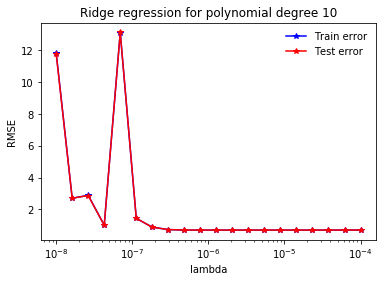

In [57]:
weights_no_nan, degree_no_nan, lambda_no_nan = test_ridge_regression(
    x_no_nan, y_train, x_no_nan_val, y_validation, degrees = np.linspace(10,10,1), lambdas=np.logspace(-8,-4, 20))

## Submission


In [58]:
y_test, x_test, ids_test, header = helper.load_csv_data(DATA_TEST)
x_test[x_test == -999] = np.nan

In [59]:
x_no_nan_test = x_test.copy()
x_no_nan_test, _ = ml.augmented_feat_angle(x_no_nan_test, id_angle, header)
x_no_nan_test, _ = ml.add_nan_feature(x_no_nan_test, id_nan, header)
x_no_nan_test = add_features(x_no_nan_test, new_feats)
x_no_nan_test = remove_useless(x_no_nan_test, id_useless=id_angle)
x_no_nan_test = normalize_outliers_feed(x_no_nan_test, mean_train, std_train, max_train, distrib)
x_no_nan_test = np.nan_to_num(x_no_nan_test)
print('\nStd:', np.std(x_no_nan_test, axis=0),'\nn_feat', x_no_nan_test.shape[1])

/home/abbet/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in greater
/home/abbet/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:53: RuntimeWarning: invalid value encountered in less



Std: [ 1.0739  1.0389  1.149   1.1334  0.5516  0.6303  0.5892  1.0158  1.1171
  1.1355  1.107   1.0015  0.5385  1.1449  0.9997  1.1455  1.0002  1.1345
  1.1064  1.0007  0.889   0.7718  0.6213  0.5391  1.1289  0.9991  1.0005
  1.0003  0.7754  0.5394  1.0009  0.9992  0.9997  0.7734  0.5398  0.9992
  1.0005  0.9997  1.0386  0.5883  1.0473  0.5472  0.9993  1.001   0.5594
  0.566   0.5941  1.0026  1.0554  1.1094  1.0007  1.0774  0.5892  1.0828
  0.9623  1.0705  0.5899  0.5546  1.0481  0.5709  0.6038  0.5451  1.0425
  1.0808  1.0004  0.5386  0.5874  1.0877  1.0451  0.6101  0.5913  1.0629
  0.6006  0.5783  0.5797] 
n_feat 75


In [60]:
degree_opt = degree_no_nan
weights_opt = weights_no_nan

_phi_test = lib.build_poly(x_no_nan_test, degree_opt)
y_pred = helper.predict_labels(weights_opt, _phi_test)

In [61]:
helper.create_csv_submission(ids_test, y_pred, 'ridge_no_nan1.csv')
print('Results saved ...')

Results saved ...
